In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchsummary

In [ ]:
transform = transforms.Compose(
    [
     transforms.ToTensor()
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=2048,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=2048,
                                          shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


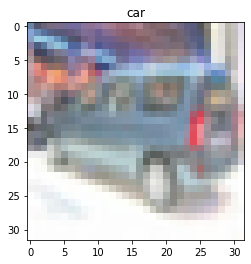

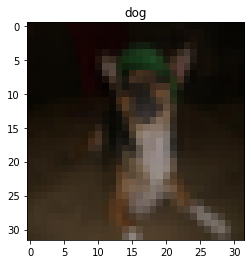

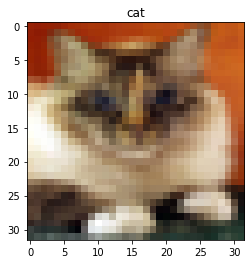

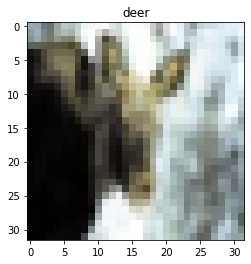

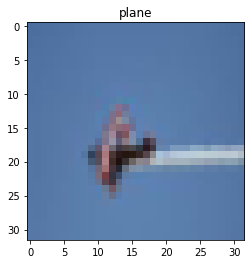

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

for data in trainloader :
  images, labels = data
  break

img = images[0]
lab = labels[0]

def imshow(img, lab) :
  npimg = img.numpy()
  npimg = np.moveaxis(npimg, 0, -1)
  plt.imshow(npimg)
  plt.title(classes[lab])
  plt.show()


for i, (img, lab) in enumerate(zip(images, labels)) :
  if i>4 : break;
  imshow(img, lab)



In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module) : #this is one simple layer but not yet network
  def __init__(self) :
    #define layers
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16,
                          kernel_size=5)
    self.pool = nn.MaxPool2d(kernel_size=(2,2))
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=64,
                          kernel_size=5)
    self.fc1 = nn.Linear(in_features=5*5*64, out_features=256)
    self.fc2 = nn.Linear(in_features=256, out_features=10)


  def forward(self, x) : #x = input img
    x = self.pool(F.relu(self.conv1(x))) #32 -> 28 -> 14
    x = self.pool(F.relu(self.conv2(x))) #14 -> 10 -> 5
    # x.shape = (64,5,5) 64 from out_channel 5*5
    # estimated shape of x = (10)
    x = x.view(-1, 5*5*64) #flatten by make 3dimensional into 1
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x #output data


net = Net() 
#If run by GPU add these 2 lines
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
torchsummary.summary(net, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]           1,216
         MaxPool2d-2           [-1, 16, 14, 14]               0
            Conv2d-3           [-1, 64, 10, 10]          25,664
         MaxPool2d-4             [-1, 64, 5, 5]               0
            Linear-5                  [-1, 256]         409,856
            Linear-6                   [-1, 10]           2,570
Total params: 439,306
Trainable params: 439,306
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.18
Params size (MB): 1.68
Estimated Total Size (MB): 1.87
----------------------------------------------------------------


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() #Lossfunction
optimizer = optim.Adam(net.parameters()) #update the lossfuntion

In [ ]:
%%time
for epoch in range(5) :
  running_loss = 0.0
  for i, data in enumerate(trainloader) :
    inputs, labels = data[0].to(device),data[1].to(device) #send the data todevice if u want to use GPU

    optimizer.zero_grad()

    outputs = net(inputs) #prediction output
    loss = criterion(outputs, labels) #calculate the loss from labels
    loss.backward() #back proporgation
    optimizer.step() #the weight is updated now
    
    running_loss += loss.item()

  print('epoch : {}, loss : {:.3f}'.format(epoch+1, running_loss/(i+1)))
  running_loss = 0.0


epoch : 1, loss : 2.018
epoch : 2, loss : 1.742
epoch : 3, loss : 1.616
epoch : 4, loss : 1.530
epoch : 5, loss : 1.468
CPU times: user 28.2 s, sys: 1.94 s, total: 30.1 s
Wall time: 30.1 s


frog


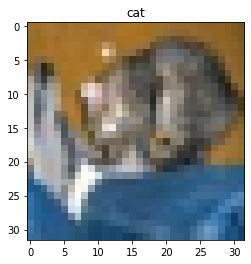

car


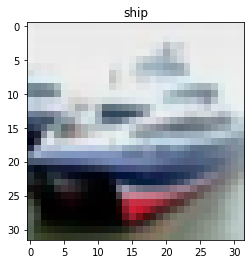

truck


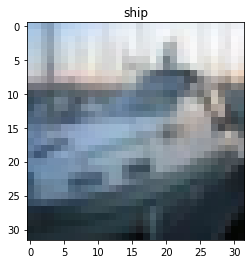

ship


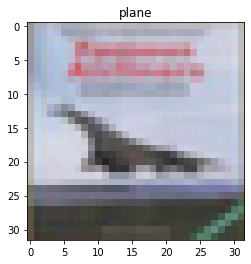

In [ ]:
with torch.no_grad() : #u will not do back propogate
  for i, data in enumerate(testloader) : #test thedata #get 1 batch data from testloader
    inputs, labels = data[0].to(device),data[1].to(device) #send the data todevice if u want to use GPU
    break;
  outputs = net(inputs) #get output using network upthere
  _,predicts = torch.max(outputs.data,1)

for i, (input, label, predict) in enumerate(zip(inputs, labels, predicts)) :
  if i == 4 : break;
  input = input.cpu()
  label = label.cpu()
  predict = predict.cpu()
  print(classes[predict])
  imshow(input, label)

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad() :
  for data in testloader :
    images, labels = data[0].to(device),data[1].to(device) #send the data todevice if u want to use GPU
    outputs = net(images)
    _,predicts = torch.max(outputs, 1)

    c = (predicts==labels).squeeze() #if predicttion = correct then return 1 or true
    
    for i in range(2048) :
      try :
        label = labels[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1
      except : 
        pass

for i in range(10) :
  print('Accuracy of {} : {}'.format(
      classes[i], 100*class_correct[i]/class_total[i]
  ))
    
    

Accuracy of plane : 50.7
Accuracy of car : 50.3
Accuracy of bird : 25.8
Accuracy of cat : 31.0
Accuracy of deer : 42.0
Accuracy of dog : 53.5
Accuracy of frog : 60.3
Accuracy of horse : 61.5
Accuracy of ship : 31.2
Accuracy of truck : 60.7
